References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet
https://www.kaggle.com/asilvaigor/learning-alexnet
https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.7.0
numpy Version: 1.19.5


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

# Code to generate embeddings:

In [ ]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        im, an image of shape (im_size, im_size, 3)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[0]
    im_size_horizontal = im.shape[1]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=0)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=1)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [ ]:
def compute_neuron_output_alt(layer_indices, images, plot_activity = False):

    '''
    arg(s):
        layer_indices: list of the indices of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_layers = len(layer_indices)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    
    for layer_index in layer_indices:
        layer = model.layers[layer_index] 
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        ## note: always take the images as inputs
        output_layer = K.function(inputs=[model.layers[1].input], 
                              outputs=[layer.output])
        
        ## output is n feature maps
        neuron_output = output_layer(images)[0]
   
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        n_neurons = n_row * n_col
        
#         ## remove the neurons at the edges
#         neuron_removed_index = neuron_index[:,2:(n_row-2),2:(n_col-2),:]
#         n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
#         n_neurons = n_row * n_col
        
        neuron_index = np.empty((n_row,n_col),dtype=int)
        index = 0
        for i in range(n_row):
            for j in range(n_col):
                neuron_index[i, j] = index
                index += 1
                
        ## obtain the index of the neurons at the edges
        neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        ## re-label the neurons at the edge with a different color
        neuron_labels = []
        for i in range(10):    
            neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
            neuron_labels = np.array(neuron_labels)
            neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = np.transpose(neuron_output, (0, 2, 1)) 
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1:
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

        
    neuron_labels = np.array(neuron_labels)     
    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

In [ ]:
def show_stimuli(layer_indices, n_images_per_class, image_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices
        n_images_per_class
        image_classes
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    # select images from specified classes:
    
    n_classes = len(image_classes)
    n_images = n_classes * n_images_per_class
    
    for i in range(n_classes):
        idx = (y_train == image_classes[i]).reshape(x_train.shape[0])
        images = x_train[idx]
        ## images has shape (5000, 32, 32, 3), take the first n_images_per_class images from each selected class:
        images = images[0:n_images_per_class,:,:,:]
        if i == 0:
            images_selected_classes = images
        else:
            images_selected_classes = np.vstack((images_selected_classes, images))
    
    images_selected_classes = np.array(images_selected_classes)
    
    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, images_selected_classes, plot_activity = plot_activity)
    
    else:
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, 1)

            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, im_all_shifts, plot_activity = False)
            ## neuron_output_highest is of shape (number of shifts, neurons)

            ## take the average over all shifts of im
            shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
            shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
            
            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                neuron_output_highest_with_shifts = shifts_avg 
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                
        neuron_output_highest = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

In [ ]:
def generate_embedding():
    neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels= show_stimuli(layer_indices = [0,1], n_images_per_class = 10, image_classes = [3,1,0,5], shifts = True)
    from sklearn.decomposition import PCA
    pca = PCA(10)
    neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
    neuron_output_highest_with_shifts_projected.shape
    import plotly.graph_objects as go
    import plotly.express as px

    fig = go.Figure()
    traces = []
    colors_palette = px.colors.qualitative.Dark24
    data = neuron_output_highest_with_shifts_projected

    for i, label in enumerate(set(neuron_labels)):
        mask = (neuron_labels == label)
        print(label, sum(mask))
        traces.append(go.Scatter3d(
            x=data[mask,0],
            y=data[mask,1],
            z=data[mask,2],
            mode='markers',
            marker=dict(
                size=4,
                color=colors_palette[int(label)],
                opacity=1,

                #showscale= True,
            )))

    for trace in traces:
        fig.add_trace(trace)

    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
    fig.show()

# Training AlexNet:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
print(torch.__version__)

1.10.0+cu111


In [ ]:
print(torchvision.__version__)

0.11.1+cu111


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


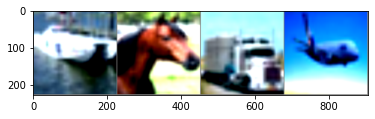

 Ship Horse Truck Airplane


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [ ]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [ ]:
# AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

In [ ]:
# import torch.nn as nn
# AlexNet_Model.classifier[1] = nn.Linear(9216,4096)
# AlexNet_Model.classifier[4] = nn.Linear(4096,1024)
# AlexNet_Model.classifier[6] = nn.Linear(1024,10)

In [ ]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, 11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(64, 192, 5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(192, 384, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
# from torch.utils import model_zoo
# def alexnet_classifier(num_classes):
#     classifier = nn.Sequential(
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(9216,4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(4096,1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024,num_classes),
#             nn.Softmax(),
#         )
#     return classifier

# def alexnet(num_classes, pretrained=False, **kwargs):
#     """AlexNet model architecture from the
#     `"One weird trick..." `_ paper.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = AlexNet(**kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'))
#         for p in model.features.parameters():
#             p.requires_grad=False
#     classifier = alexnet_classifier(num_classes)
#     model.classifier = classifier
#     return model
# model = alexnet(10, True)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


In [ ]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 1')

[1,  2000] loss: 2.184
Time: 53.47821497917175
[1,  4000] loss: 1.832
Time: 108.97304320335388
[1,  6000] loss: 1.646
Time: 167.0615439414978
[1,  8000] loss: 1.487
Time: 216.7860724925995
[1, 10000] loss: 1.389
Time: 266.18605279922485
[1, 12000] loss: 1.273
Time: 317.10622334480286
Finished Training of AlexNet: Epoch 1


In [ ]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 11, 11])
(54, 106, 3)


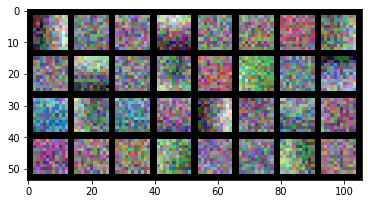

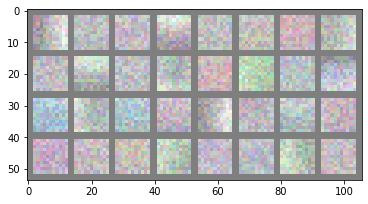

In [ ]:
show_weights(AlexNet_Model.conv_layer1)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


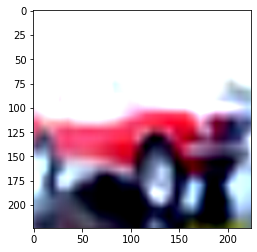

In [ ]:
imshow(images[0])

In [ ]:
images = images.type(torch.cuda.FloatTensor)
im = images[0]

In [ ]:
# def plot_intermediate_layers(image, net, return_layers):
#   # Get output for the image from the intermediate layers
#   intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
#   fig = plt.figure(figsize=(12, 3))
#   ax=fig.add_subplot(141)
#   ax.imshow(image.squeeze(0).permute(1, 2, 0))
#   plt.axis('off')
#   plt.title('Original Image')
#   ax=fig.add_subplot(142)
#   ax.imshow(intermediate_output[0]['v1'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V1 layer (Average)')
#   ax=fig.add_subplot(143)
#   ax.imshow(intermediate_output[0]['v2'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V2 layer (Average)')
#   ax=fig.add_subplot(144)
#   ax.imshow(intermediate_output[0]['v4'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V4 layer (Average)')
#   plt.show()

In [ ]:
!pip install torch_intermediate_layer_getter

  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=8472b25a6a54c00e45a9c7e377bfb7d5f13c2e777c20468e9843b7b4169f5fa5
  Stored in directory: /root/.cache/pip/wheels/59/53/37/8b81c4711686fbae03a35d8d1dac5edd9e4af9221fa8e17f6f
Successfully built torch-intermediate-layer-getter


In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 192, 13, 13])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

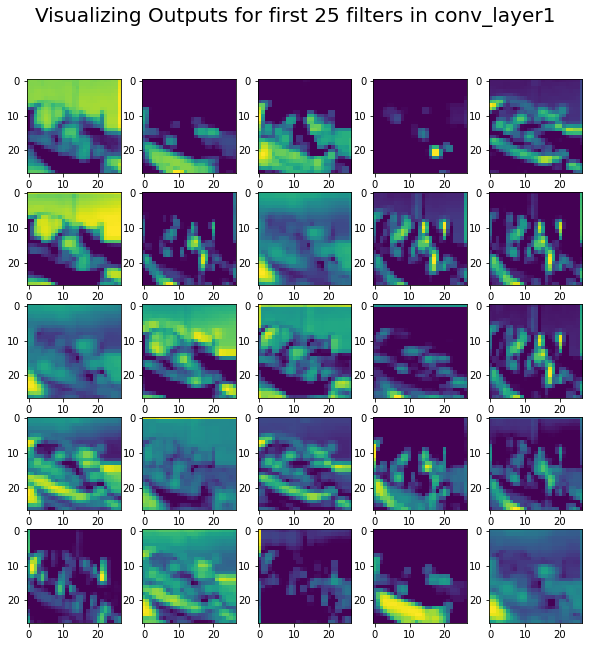

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

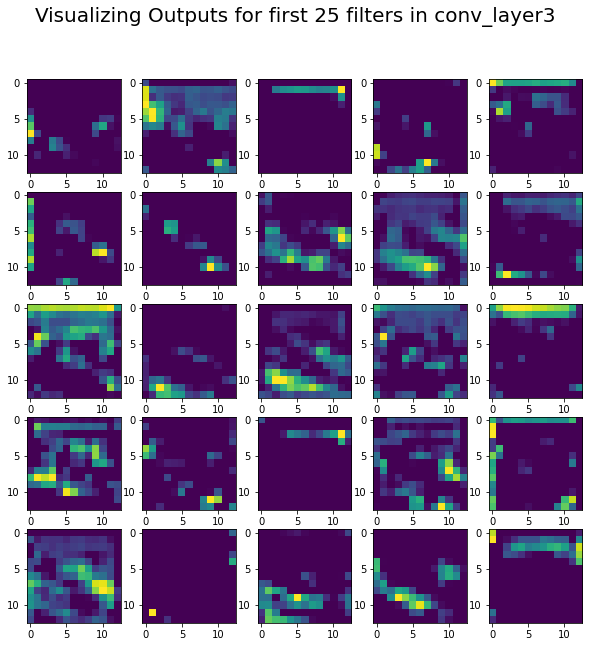

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

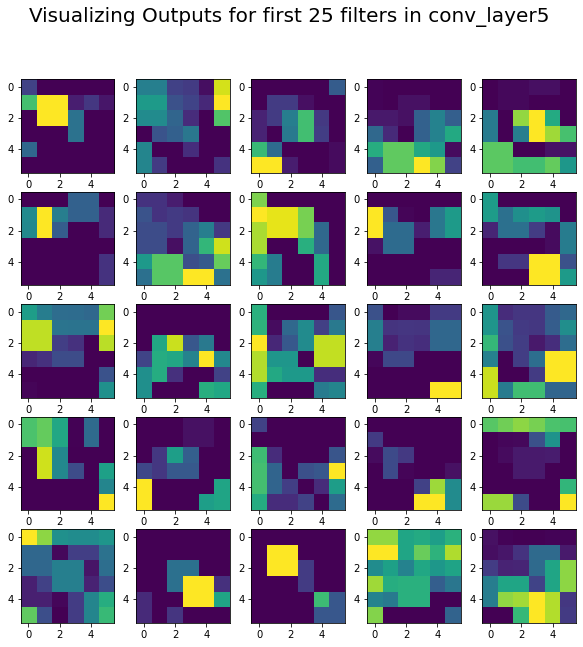

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 2')

[1,  2000] loss: 1.146
Time: 52.82818794250488
[1,  4000] loss: 1.057
Time: 97.79924964904785
[1,  6000] loss: 1.008
Time: 136.92889189720154
[1,  8000] loss: 0.957
Time: 176.78873753547668
[1, 10000] loss: 0.899
Time: 215.73955965042114
[1, 12000] loss: 0.878
Time: 254.92870426177979
Finished Training of AlexNet: Epoch 2


In [ ]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

torch.Size([32, 3, 11, 11])
(54, 106, 3)


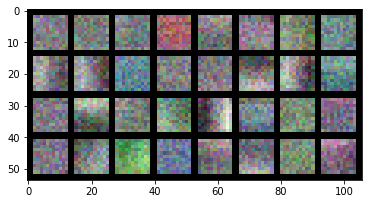

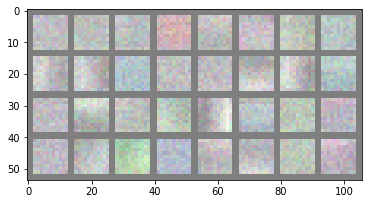

In [ ]:
show_weights(AlexNet_Model.conv_layer1)

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
print(im.shape)
# im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 192, 13, 13])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

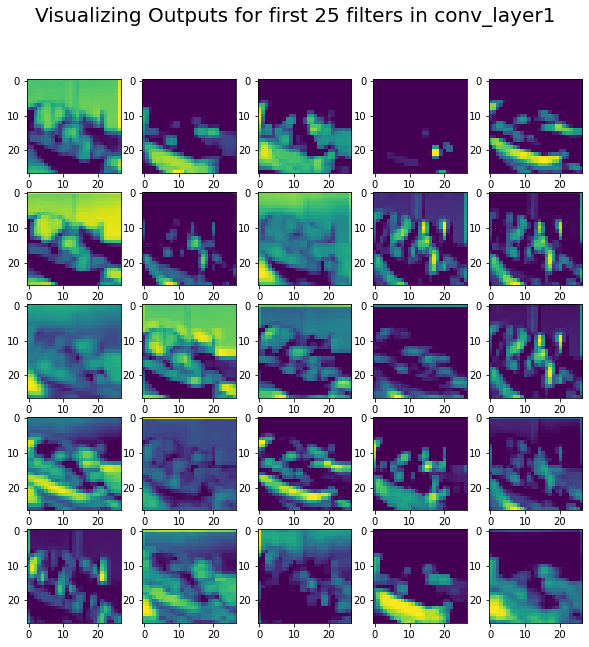

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

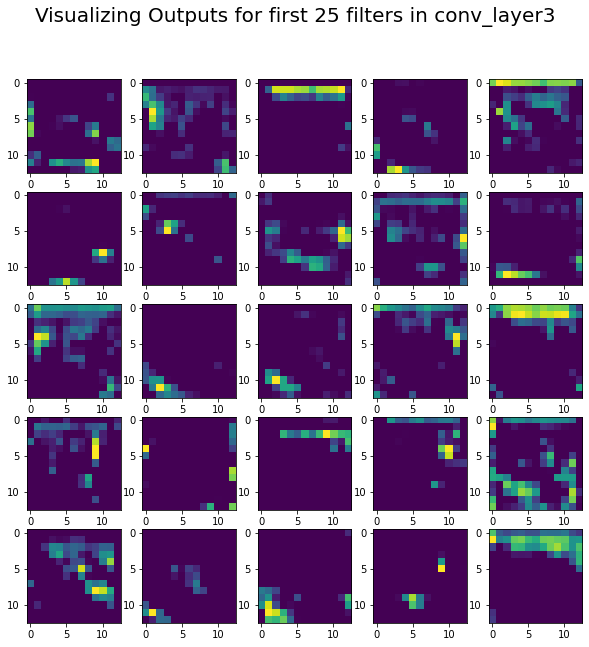

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

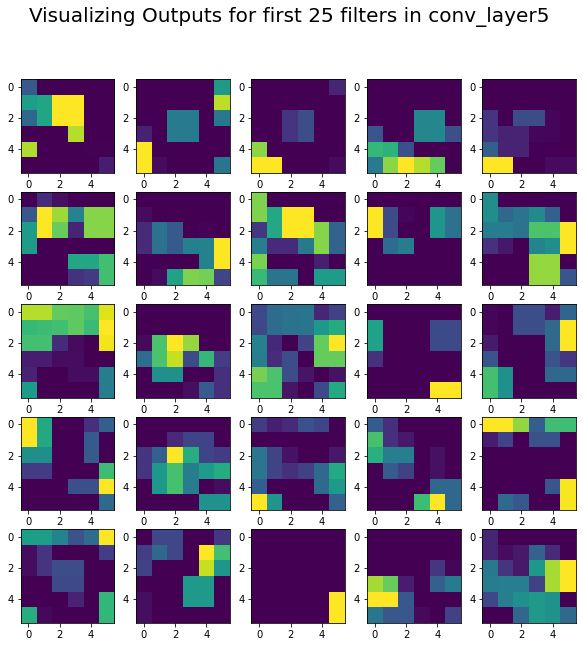

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 5')

[1,  2000] loss: 0.736
Time: 47.391913414001465
[1,  4000] loss: 0.722
Time: 86.715087890625
[1,  6000] loss: 0.724
Time: 139.32626819610596
[1,  8000] loss: 0.691
Time: 179.5993926525116
[1, 10000] loss: 0.693
Time: 219.47159624099731
[1, 12000] loss: 0.683
Time: 258.9338479042053
[2,  2000] loss: 0.474
Time: 39.488900661468506
[2,  4000] loss: 0.525
Time: 80.62948846817017
[2,  6000] loss: 0.535
Time: 119.97664213180542
[2,  8000] loss: 0.540
Time: 159.36457872390747
[2, 10000] loss: 0.514
Time: 199.60013341903687
[2, 12000] loss: 0.532
Time: 238.98780488967896
[3,  2000] loss: 0.323
Time: 39.40997624397278
[3,  4000] loss: 0.359
Time: 78.84495902061462
[3,  6000] loss: 0.372
Time: 118.4470386505127
[3,  8000] loss: 0.373
Time: 158.15641069412231
[3, 10000] loss: 0.384
Time: 197.3597092628479
[3, 12000] loss: 0.385
Time: 236.39848113059998
Finished Training of AlexNet: Epoch 5


In [ ]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

torch.Size([32, 3, 11, 11])
(54, 106, 3)


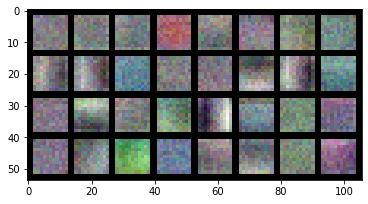

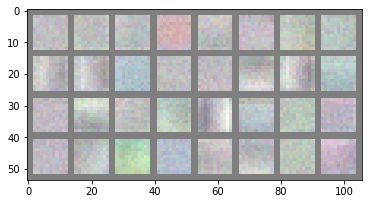

In [ ]:
show_weights(AlexNet_Model.conv_layer1)

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
print(im.shape)
# im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 192, 13, 13])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

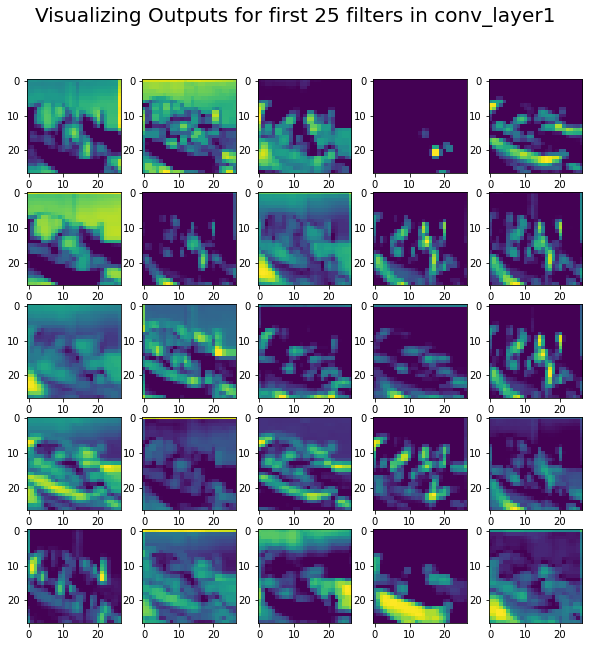

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

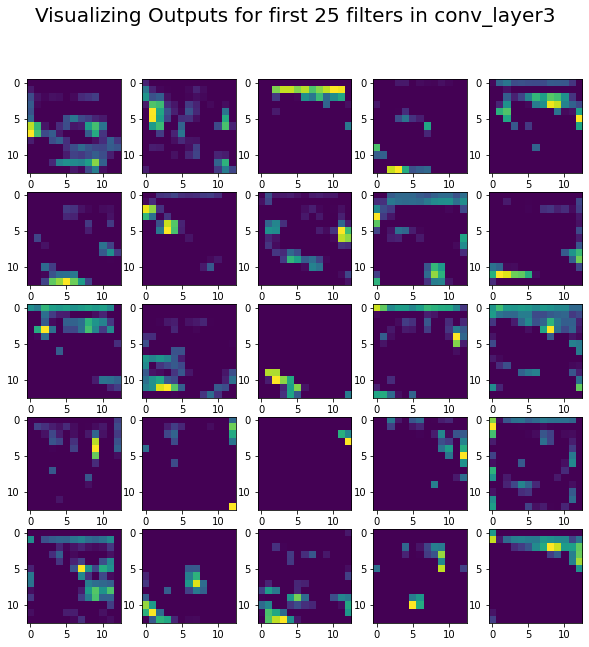

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

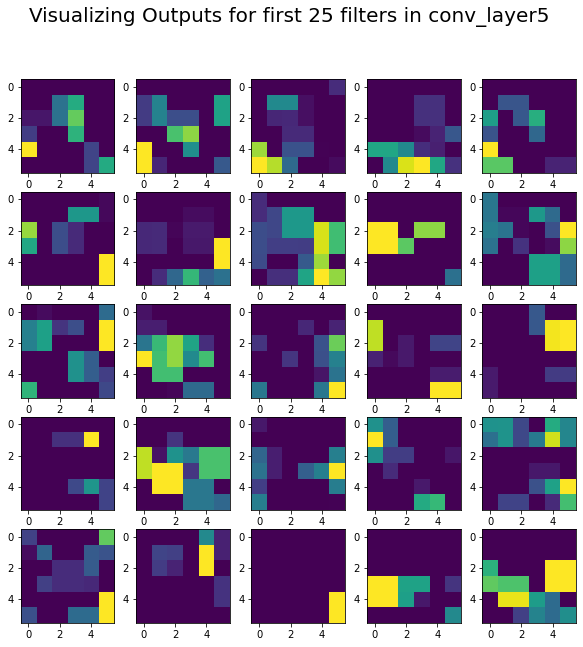

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 10')

[1,  2000] loss: 0.197
Time: 48.91603493690491
[1,  4000] loss: 0.225
Time: 97.38828635215759
[1,  6000] loss: 0.235
Time: 136.55714678764343
[1,  8000] loss: 0.273
Time: 176.52094316482544
[1, 10000] loss: 0.280
Time: 215.68394923210144
[1, 12000] loss: 0.273
Time: 254.66687655448914
[2,  2000] loss: 0.142
Time: 40.04827308654785
[2,  4000] loss: 0.142
Time: 80.23481106758118
[2,  6000] loss: 0.179
Time: 119.13718962669373
[2,  8000] loss: 0.180
Time: 158.01888871192932
[2, 10000] loss: 0.193
Time: 197.0584316253662
[2, 12000] loss: 0.199
Time: 236.3043179512024
[3,  2000] loss: 0.097
Time: 39.30751013755798
[3,  4000] loss: 0.112
Time: 78.39879584312439
[3,  6000] loss: 0.140
Time: 117.39269471168518
[3,  8000] loss: 0.140
Time: 156.82785654067993
[3, 10000] loss: 0.136
Time: 195.5696291923523
[3, 12000] loss: 0.159
Time: 234.27915453910828
[4,  2000] loss: 0.080
Time: 39.28517746925354
[4,  4000] loss: 0.081
Time: 78.21283674240112
[4,  6000] loss: 0.101
Time: 117.26263046264648
[4,

In [ ]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

torch.Size([32, 3, 11, 11])
(54, 106, 3)


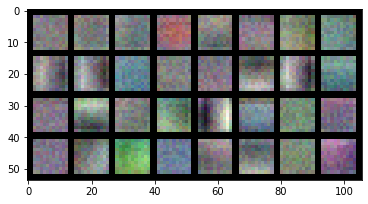

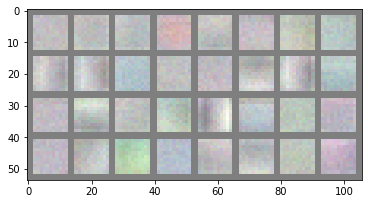

In [ ]:
show_weights(AlexNet_Model.conv_layer1)

In [ ]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer2': 'conv_layer2',
      'conv_layer3': 'conv_layer3',
      'conv_layer4': 'conv_layer4',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
print(im.shape)
# im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 192, 13, 13])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

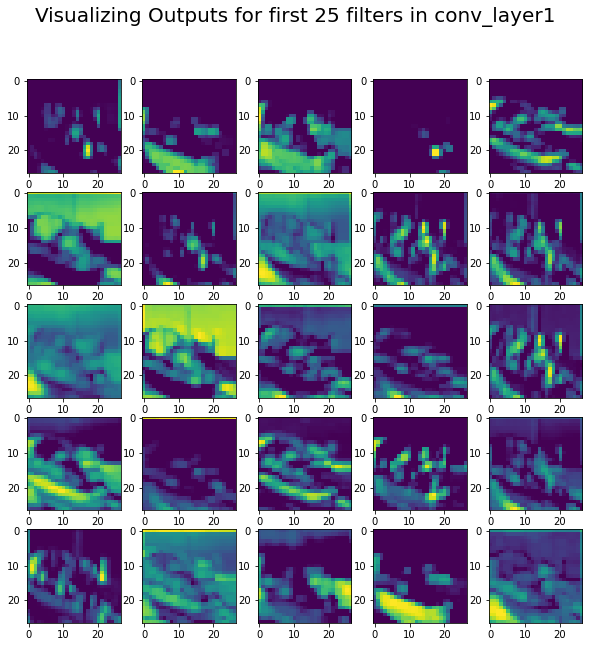

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

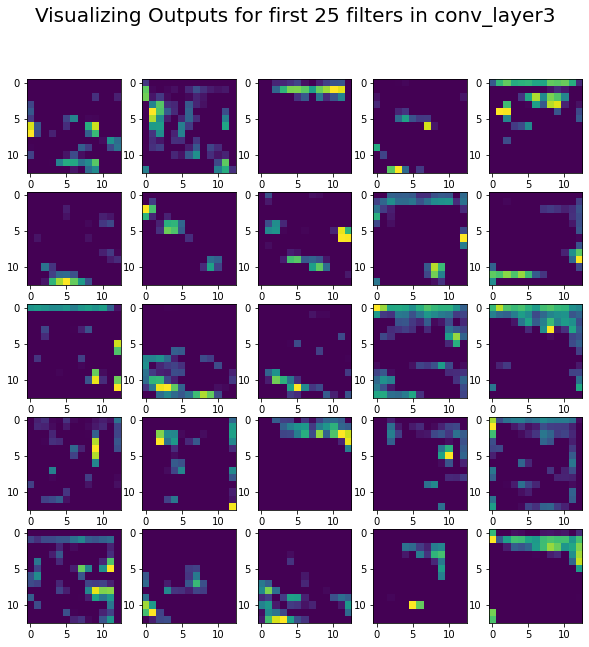

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

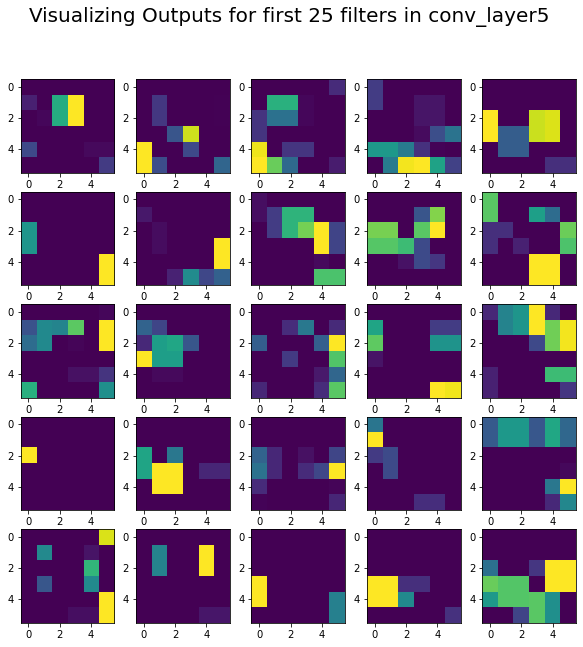

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)